In [ ]:
!pip install torchvision 
!pip install kaggle kagglehub

In [2]:
import torch

import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets, transforms, models

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import pandas as pd
import numpy as np

import os
import kagglehub

from PIL import Image

import matplotlib.pyplot as plt

In [3]:
path = kagglehub.dataset_download("sudipde25/mri-dataset-for-detection-and-analysis")
print("Path to dataset files:", path)

# path = "/ccsopen/home/dom_p/.cache/kagglehub/datasets/sudipde25/mri-dataset-for-detection-and-analysis/versions/21"

100%|██████████| 6.46G/6.46G [01:29<00:00, 77.4MB/s]

Extracting files...


Path to dataset files: /ccsopen/home/maggiemiller/.cache/kagglehub/datasets/sudipde25/mri-dataset-for-detection-and-analysis/versions/27


In [4]:
# Define the device (use GPU, otherwise use CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Using the established path, sets the location of image folders (says images are here)
data_dir = path + "/NINS_Dataset/NINS_Dataset/"
batch_size = 32

# Finds folders with actual image files
def find_valid_image_folders(root_dir):
    valid_folders = []
    for entry in os.listdir(root_dir):
        folder_path = os.path.join(root_dir, entry)
        # Consider it valid if it's a directory and not 'model' and contains images
        if (os.path.isdir(folder_path) and 
            entry != 'model' and 
            any(file.endswith(('.jpg', '.jpeg', '.png')) for file in os.listdir(folder_path))):
            valid_folders.append(folder_path)
    return valid_folders

# Get the valid image folders
valid_image_folders = find_valid_image_folders(data_dir)
num_classes = len(valid_image_folders)  # Number of classes based on subdirectory

# Create composed dataset using the valid directories found
images = []
labels = []

# Assigns a number to each folder 
for folder in valid_image_folders:
    class_label = valid_image_folders.index(folder)  # Get label based on folder index
    for image_file in os.listdir(folder):
        if image_file.endswith(('.jpg', '.jpeg', '.png')):
            images.append(os.path.join(folder, image_file))  # Adds path of image to images list
            labels.append(class_label)  # Adds matching label number to labels list

# Data pre-processing
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize the images to 224x224 for the model
    transforms.ToTensor(),  # Converts image to a tensor
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize images
])

# for class_dir in os.listdir(data_dir):
#     print(os.listdir(os.path.join(data_dir, class_dir)))  # Lists image files in each class

In [5]:
# Creates custom dataset class
class CustomImageDataset(torch.utils.data.Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform
# Number of samples
    def __len__(self):
        return len(self.images)
# Takes each image and labels it, transforms it, and returns it
    def __getitem__(self, idx):
        img_path = self.images[idx]
        image = Image.open(img_path).convert("RGB")
        label = self.labels[idx]

        if self.transform:
            image = self.transform(image)

        return image, label

# Create an instance of the custom dataset
dataset = CustomImageDataset(images=images, labels=labels, transform=transform)

# Load the data into a DataLoader (Wraps the dataset so it can feed the model during training)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [6]:
# Split images and labels into 80% train, 20% test
train_images, test_images, train_labels, test_labels = train_test_split(
    images, labels, test_size=0.2, random_state=42, stratify=labels
)

# Create datasets
train_dataset = CustomImageDataset(train_images, train_labels, transform=transform)
test_dataset = CustomImageDataset(test_images, test_labels, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [7]:
# Load a pre-trained model (ResNet50)
model = models.resnet50(weights='IMAGENET1K_V2')
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)  # Adjust the final layer to match the number of classes
model = model.to(device) # Moves model to GPU or CPU

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Defines how the model is graded
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Tells model how to update weights

# Training loop
def train_model(model, criterion, optimizer, dataloader, num_epochs):
    model.train()  # Set the model to training mode
    for epoch in range(num_epochs):
        running_loss = 0.0
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Backward pass and optimize
            loss.backward()
            optimizer.step()

            running_loss += loss.item()

        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(dataloader)}')  # Tracks loss progress

# Train the model
train_model(model, criterion, optimizer, train_loader, num_epochs=20)

# Save the model
torch.save(model.state_dict(), "model.pth")
print("Model saved to 'model.pth'")

Epoch [1/20], Loss: 2.4242327095884266
Epoch [2/20], Loss: 1.7017421866908218
Epoch [3/20], Loss: 1.0673927249330464
Epoch [4/20], Loss: 0.6095657490871169
Epoch [5/20], Loss: 0.35810910458817624
Epoch [6/20], Loss: 0.21415895567924687
Epoch [7/20], Loss: 0.13473614468944795
Epoch [8/20], Loss: 0.1747408062360729
Epoch [9/20], Loss: 0.06929393749415988
Epoch [10/20], Loss: 0.06539602915290743
Epoch [11/20], Loss: 0.10992887813005257
Epoch [12/20], Loss: 0.1754726492447045
Epoch [13/20], Loss: 0.09102750677530738
Epoch [14/20], Loss: 0.02943464643127906
Epoch [15/20], Loss: 0.027693432198826817
Epoch [16/20], Loss: 0.16936326881863573
Epoch [17/20], Loss: 0.12547884592045608
Epoch [18/20], Loss: 0.05278505582828075
Epoch [19/20], Loss: 0.018147755360008556
Epoch [20/20], Loss: 0.0027102213823651036
Model saved to 'model.pth'


In [8]:
def evaluate_model(model, dataloader):
    model.eval()  # Set the model to evaluation mode
    correct = 0
    total = 0

    with torch.no_grad():  # No gradient calculation needed
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)  # Get class with highest score

            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f'Accuracy on test data: {accuracy:.2f}%')

In [9]:
evaluate_model(model, test_loader)

Accuracy on test data: 89.81%


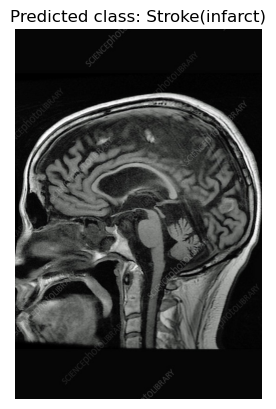

In [11]:
# Load and preprocess the new image
def predict_single_image(image_path, model, transform, class_names=None):
    model.eval()  # Make sure model is in eval mode

    # Open and transform the image
    image = Image.open(image_path).convert("RGB")
    input_tensor = transform(image).unsqueeze(0).to(device)  # Add batch dimension

    with torch.no_grad():
        output = model(input_tensor)
        _, predicted = torch.max(output, 1)

    class_idx = predicted.item()
    
    if class_names:
        return class_names[class_idx]
    else:
        return class_idx

# Example usage
image_path = "brain_atrophy.jpg"  # Change to your actual file name
class_names = os.listdir(data_dir)  # Assuming class names are subfolder names
class_names.sort()  # Make sure they're in the right order

prediction = predict_single_image(image_path, model, transform, class_names)

image = Image.open(image_path)
plt.imshow(image)
plt.title(f"Predicted class: {prediction}")
plt.axis('off')
plt.show()